In [3]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import logging
import random
import pkg_resources
import sklearn
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from transformers import get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics.pairwise import pairwise_distances
#from rxnfp.tokenization import *
# from rdkit import Chem
# from rdkit.Chem import rdChemReactions
torch.cuda.is_available()
#import rxnfp
#from rxnfp.models import SmilesClassificationModel
#from rxn_yields.core import SmilesTokenizer, SmilesClassificationModel§1`

logger = logging.getLogger(__name__)
#torch.cuda.is_available()
# from simpletransformers.classification import ClassificationModel, ClassificationArgs
#from rxnfp.tokenization import SmilesTokenizer

/opt/conda/envs/reaction-workbench-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
from rxnfp.tokenization import SmilesTokenizer

import os
import pickle

import argparse

from tqdm.auto import tqdm
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

### Train Embedding

In [4]:
from transformers import AutoModel

model_path = '../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36'
pretrained_model = AutoModel.from_pretrained(model_path, output_hidden_states=True)
tokenizer = SmilesTokenizer(vocab_file='../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36/vocab.txt')

Some weights of BertModel were not initialized from the model checkpoint at ../Janssen_project/rxn-data-from-postgresql/models/reaxys_bert/checkpoint-4356432-epoch-36 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
df_class = pd.read_csv('data/className.tsv', sep='\t', encoding='ISO-8859-1')

In [14]:
# Convert multi Class-ID into one
def clean_class_id(row):
    # Split the string by comma and convert to a list
    class_ids = str(row['CLASS-ID']).split(',')
    # Return the first element from the list, ensuring it's an integer
    return int(class_ids[0].strip())

# Apply the function to the 'CLASS-ID' column
df_class['CLASS-ID'] = df_class.apply(clean_class_id, axis=1)
df_class['CLASS-ID'] = df_class['CLASS-ID'].astype(int)

In [15]:
df_class['SUPER_TRANSFORM_ID'] = df_class['TRANSFORM_ID'].str.extract(r'\((.*?)\)')

In [16]:
df_Name = pd.merge(train, df_class[['CLASS-ID', 'TRANSFORM_NAME', 'TRANSFORM_ID', 'SUPER_TRANSFORM_ID']], on='CLASS-ID', how='left')

In [18]:
df_Name = df_Name.drop(columns="product_summary")
df_Name = df_Name.drop(columns="RX.ID")

In [19]:
embeddings = X_train 
df_Name['embedding'] = list(embeddings)

In [20]:
class PairDataset:
    def __init__(self, dataframe):
        self.df = dataframe
        self.pairs = []
        self.targets = []
        self.create_pairs()

    def create_pairs(self):
        positive_pairs = []
        negative_pairs = []
        positive_targets = []
        negative_targets = []

        # Generate positive pairs (label 0 for similar)
        for _, group in tqdm(self.df.groupby('CLASS-ID'), desc='Positive Pairs'):
            indices = group.index.tolist()
            for i in range(len(indices)):
                pair_index = (i + 1) % len(indices)
                positive_pairs.append((indices[i], indices[pair_index]))
                positive_targets.append(0)  # Positive pair (similar)

        # Generate negative pairs (label 1 for dissimilar)
        for _, super_group in tqdm(self.df.groupby('SUPER_TRANSFORM_ID'), desc='Negative Pairs'):
            class_groups = list(super_group.groupby('CLASS-ID'))
            super_transform_id = super_group['SUPER_TRANSFORM_ID'].iloc[0]

            if super_transform_id != 'AVNAMEDR':  # For reactions not in AVNAMEDR
                other_super_groups = [g for g in self.df.groupby('SUPER_TRANSFORM_ID') if g[0] != super_transform_id]
                for class_group in class_groups:
                    indices = class_group[1].index.tolist()
                    if len(other_super_groups) > 0:
                        for i in range(len(indices)):
                            selected_super_group_index = np.random.choice(len(other_super_groups), 1)[0]
                            selected_super_group = other_super_groups[selected_super_group_index]
                            selected_super_group_indices = selected_super_group[1].index.tolist()
                            if len(selected_super_group_indices) > 0:
                                selected_index = np.random.choice(selected_super_group_indices, 1)[0]
                                negative_pairs.append((indices[i], selected_index))
                                negative_targets.append(1)  # Negative pair (dissimilar)
            else:  # For reactions in AVNAMEDR
                if len(class_groups) > 1:
                    for class_group in class_groups:
                        indices = class_group[1].index.tolist()
                        other_class_groups = [g for g in class_groups if g[0] != class_group[0]]
                        for i in range(len(indices)):
                            if len(other_class_groups) > 0:
                                selected_group_index = np.random.choice(len(other_class_groups), 1)[0]
                                selected_group = other_class_groups[selected_group_index]
                                selected_indices = selected_group[1].index.tolist()
                                if len(selected_indices) > 0:
                                    selected_index = np.random.choice(selected_indices, 1)[0]
                                    negative_pairs.append((indices[i], selected_index))
                                    negative_targets.append(1)  # Negative pair (dissimilar)

        # Assign pairs and targets
        self.pairs = positive_pairs + negative_pairs
        self.targets = positive_targets + negative_targets
    def plot_distance_distributions(self, num_samples=100):
        positive_distances = []
        negative_distances = []

        sample_indices = np.random.choice(len(self.pairs), num_samples, replace=False)
        for idx in sample_indices:
            pair = self.pairs[idx]
            target = self.targets[idx]
            embedding1 = self.df.loc[pair[0], 'embedding']
            embedding2 = self.df.loc[pair[1], 'embedding']
            distance = euclidean(embedding1, embedding2)

            if target == 0:
                positive_distances.append(distance)
            else:
                negative_distances.append(distance)

        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))

        sns.histplot(positive_distances, bins=30, color="#f45f74", alpha=0.7, label='Positive Pairs')  # Med Pink
        sns.histplot(negative_distances, bins=30, color="#00b0be", alpha=0.7, label='Negative Pairs')  # Med Blue

        plt.xlabel('Distance')
        plt.ylabel('Frequency')
        plt.title('Distance Distribution of Positive and Negative Pairs(Pre-trained Bert)')
        plt.legend(loc='upper right')

        plt.tight_layout()
        plt.show()

In [21]:
sample_fraction = 0.1  # Use 10% of the data
sample_df = df_Name.sample(frac=sample_fraction, random_state=42)

# Create the dataset and dataloaders
dataset = PairDataset(sample_df)

Negative Pairs: 100%|██████████| 34/34 [00:42<00:00,  1.26s/it]


In [22]:
print(f"Total number of positive pairs: {sum(1 for t in dataset.targets if t == 1)}")
print(f"Total number of negative pairs: {sum(1 for t in dataset.targets if t == 0)}")

Total number of positive pairs: 120280
Total number of negative pairs: 120280


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

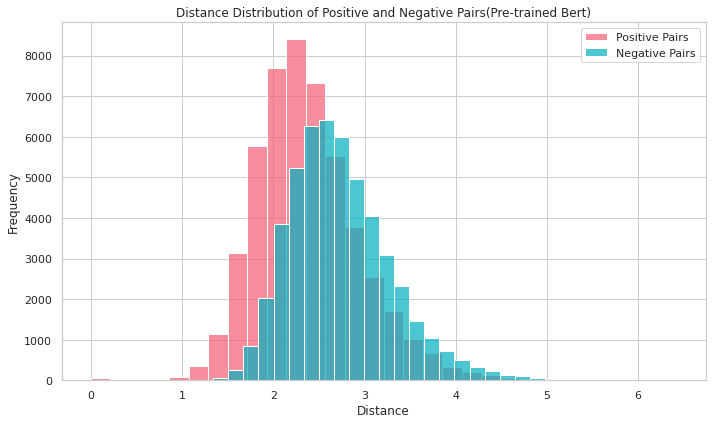

In [24]:
dataset.plot_distance_distributions(100000)

In [25]:
class ReactionPairDataset(Dataset):
    def __init__(self, dataframe, pairs, targets):
        self.df = dataframe
        self.pairs = pairs
        self.targets = targets

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        index1, index2 = self.pairs[idx]
        reaction1 = self.df.loc[index1, 'reaction']
        reaction2 = self.df.loc[index2, 'reaction']
        label = self.targets[idx]
        return reaction1, reaction2, torch.tensor(label, dtype=torch.float32)

In [26]:
reaction_dataset = ReactionPairDataset(df_Name, dataset.pairs, dataset.targets)
train_size = int(0.9 * len(reaction_dataset))
val_size = len(reaction_dataset) - train_size
train_dataset, val_dataset = random_split(reaction_dataset, [train_size, val_size])

In [27]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pretrained_model.to(device)

NameError: name 'pretrained_model' is not defined

In [26]:
device

device(type='cuda')

In [29]:
optimizer = torch.optim.AdamW(pretrained_model.parameters(), lr=1e-6) 
total_steps = len(train_dataloader) * 10  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

In [30]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
        loss = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                          label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss

In [31]:
criterion = ContrastiveLoss(margin=2.5)

In [32]:
def evaluate_model(dataloader):
    pretrained_model.eval()
    total_loss = 0
    with torch.no_grad():
        for reaction1, reaction2, target in dataloader:
            inputs1 = tokenizer(reaction1, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            inputs2 = tokenizer(reaction2, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
            target = target.to(device)
            
            embedding1 = pretrained_model(**inputs1).last_hidden_state[:, 0, :]
            embedding2 = pretrained_model(**inputs2).last_hidden_state[:, 0, :]
            
            loss = criterion(embedding1, embedding2, target)
            total_loss += loss.item()
    
    return total_loss / len(dataloader)

In [34]:
num_epochs = 5
accumulation_steps = 4 
#early_stopping_patience = 3
best_val_loss = float('inf')
#patience_counter = 0
scaler = torch.cuda.amp.GradScaler()
for epoch in range(num_epochs):
    pretrained_model.train()
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", mininterval=1)  # Update every 100 seconds
    optimizer.zero_grad()

    for i, (reaction1, reaction2, target) in enumerate(progress_bar):
        inputs1 = tokenizer(reaction1, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        inputs2 = tokenizer(reaction2, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)
        target = target.to(device)

        with torch.cuda.amp.autocast():
            embedding1 = pretrained_model(**inputs1).last_hidden_state[:, 0, :]
            embedding2 = pretrained_model(**inputs2).last_hidden_state[:, 0, :]
            loss = criterion(embedding1, embedding2, target)
            loss = loss / accumulation_steps  # Scale the loss

        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(pretrained_model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps

        # Print loss less frequently
        if (i + 1) % (len(train_dataloader) // 10) == 0:
            progress_bar.set_postfix(loss=total_loss / ((i + 1) // accumulation_steps if (i + 1) // accumulation_steps > 0 else 1))

    val_loss = evaluate_model(val_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}, Validation Loss: {val_loss}")

    scheduler.step()

Epoch 1/5: 100%|██████████| 13532/13532 [23:26<00:00,  9.62it/s, loss=7.25]


Epoch 1/5, Training Loss: 1.8117709516324907, Validation Loss: 0.9112969726086297


Epoch 2/5: 100%|██████████| 13532/13532 [23:20<00:00,  9.66it/s, loss=4.92]


Epoch 2/5, Training Loss: 1.2298022616757045, Validation Loss: 0.7000445133431795


Epoch 3/5: 100%|██████████| 13532/13532 [23:20<00:00,  9.66it/s, loss=4.18]


Epoch 3/5, Training Loss: 1.0444291631850553, Validation Loss: 0.6064364861181759


Epoch 4/5: 100%|██████████| 13532/13532 [23:21<00:00,  9.66it/s, loss=3.73]


Epoch 4/5, Training Loss: 0.9327743820407811, Validation Loss: 0.5457673034472192


Epoch 5/5: 100%|██████████| 13532/13532 [23:19<00:00,  9.67it/s, loss=3.42]


Epoch 5/5, Training Loss: 0.8558622848902128, Validation Loss: 0.4991720252511825


In [35]:
pretrained_model.save_pretrained('data/fine_tuned_model_Test')
tokenizer.save_pretrained('data/fine_tuned_model_Test')

('data/fine_tuned_model_Test/tokenizer_config.json',
 'data/fine_tuned_model_Test/special_tokens_map.json',
 'data/fine_tuned_model_Test/vocab.txt',
 'data/fine_tuned_model_Test/added_tokens.json')

### Data Load

In [5]:
X_train1 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train1_PreBertFP.npy',allow_pickle=True)
X_train2 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train2_PreBertFP.npy',allow_pickle=True)
X_train3 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train3_PreBertFP.npy',allow_pickle=True)
X_train4 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train4_PreBertFP.npy',allow_pickle=True)
X_train5 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train5_PreBertFP.npy',allow_pickle=True)
X_train6 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train6_PreBertFP.npy',allow_pickle=True)
X_train7 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train7_PreBertFP.npy',allow_pickle=True)
X_train8 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train8_PreBertFP.npy',allow_pickle=True)
X_train9 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train9_PreBertFP.npy',allow_pickle=True)
X_train10 = np.load('../ReactionClassification_2024/data/PreBertFP/X_train10_PreBertFP.npy',allow_pickle=True)

In [6]:
X_train = np.concatenate([X_train1, X_train2, X_train3, X_train4, X_train5,
                          X_train6, X_train7, X_train8, X_train9, X_train10], axis=0)

In [7]:
X_train1 = np.vstack(X_train)
X_train = np.squeeze(X_train1)

In [8]:
#X_train = np.load('data/RXNFP/X_train_RXNFP.npy')
X_test = np.load('../ReactionClassification_2024/data/PreBertFP/X_test_PreBertFP.npy',allow_pickle=True)
X_val = np.load('../ReactionClassification_2024/data/PreBertFP/X_val_PreBertFP.npy',allow_pickle=True)

In [9]:
X_test1 = np.vstack(X_test)
X_test = np.squeeze(X_test1)

In [10]:
X_val1 = np.vstack(X_val)
X_val = np.squeeze(X_val1)

In [11]:
train = pd.read_csv('../ReactionClassification_2024/data/train.csv', delimiter=',')
test = pd.read_csv('../ReactionClassification_2024/data/test.csv', delimiter=',')
val = pd.read_csv('../ReactionClassification_2024/data/val.csv', delimiter=',')

In [12]:
y_train = train['CLASS-ID'].values
y_test = test['CLASS-ID'].values
y_val = val['CLASS-ID'].values